Trying to consider three different set of values for glucose anf lactate

In [1]:
 ### Simulation of Eubacterium with lactate

%reset -f

import os
# COMETS and Gurobi paths (macOS)
os.environ['GUROBI_COMETS_HOME'] = '/Library/gurobi1003/macos_universal2'
os.environ['COMETS_HOME'] = '/Users/fredericksenya/Documents/MATLAB/comets_macos/comets_2.12.3'
os.environ['CLASSPATH'] = f"{os.environ['COMETS_HOME']}/comets.jar:{os.environ['GUROBI_COMETS_HOME']}/lib/gurobi.jar"
os.environ['DYLD_LIBRARY_PATH'] = f"{os.environ['GUROBI_COMETS_HOME']}/lib"
os.environ['GRB_LICENSE_FILE'] = '/Library/gurobi1003/macos_universal2/gurobi.lic'

In [2]:
import cobra as cb
import cometspy as c
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore', category=FutureWarning)


model_1 = cb.io.load_matlab_model("Eubacterium_hallii_DSM_3353.mat")

# open all exchanges by default
for rxn in model_1.exchanges:
    rxn.lower_bound = 0.0
    rxn.upper_bound = 1000.0

# Exchange list
all_exchanges_cobra = [rxn.id for rxn in model_1.exchanges]

met_to_ex = {
    met.id: rxn.id
    for rxn in model_1.exchanges
    for met in rxn.metabolites
    if met.compartment == 'e'
}

trace_metabolites = {
    "h2o[e]", "pi[e]", "fe2[e]", "fe3[e]", "zn2[e]", "so4[e]", "cu2[e]", "k[e]", "mg2[e]",
    "mn2[e]", "cd2[e]", "cl[e]", "ca2[e]", "cobalt2[e]", "ribflv[e]",
    "pnto_R[e]", "nac[e]", "his_L[e]", "asn_L[e]", "glycys[e]", "lys_L[e]", "ala_L[e]",
    "met_L[e]", "leu_L[e]", "hxan[e]",
}

base_media = {"nh4[e]": 20.0, "ser_L[e]": 10.0}


#glucose_values = np.array([10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=float)
#lactate_values = np.array([0,  2, 4, 6, 8, 10, 12, 14, 16, 18, 20], dtype=float)

glucose_values = np.linspace(10.0, 2.0, 51)
lactate_values = np.linspace(0.0, 16.0, 51)

# extracellular metabolite ids available in the model
ex_mets = {m.id for m in model_1.metabolites if m.compartment == "e"}


def run_simulation(glc, lac):

    model_copy = model_1.copy()
    model_copy.id = "Eubacterium"

    comets_model = c.model(model_copy)
    comets_model.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"

    comets_model.open_exchanges()

    comets_model.initial_pop = [0, 0, 0.01]

    layout = c.layout([comets_model])
    layout.grid = [1, 1]

    # Clean non-EX reactions from EXCH column
    ex_mask = comets_model.reactions["EXCH"].isin([True, "True"])
    exchanges_df = comets_model.reactions[ex_mask]
    for name in exchanges_df["REACTION_NAMES"]:
        name = str(name)
        if not name.startswith("EX_"):
            comets_model.reactions.loc[comets_model.reactions["REACTION_NAMES"] == name, "EXCH"] = False
            comets_model.reactions.loc[comets_model.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0


    # Track all external metabolites
    all_ex_mets = set(met_to_ex.keys())
    for met in all_ex_mets:
        layout.set_specific_metabolite(met, 0.0)
        layout.set_specific_refresh(met, 0.0)

    # set trace metabolites 
    for met in trace_metabolites:
        if met in ex_mets:
            layout.set_specific_metabolite(met, 1000.0)
            layout.set_specific_static(met, 1000)

    # set limited media 
    lb_media = dict(base_media)
    lb_media["glc_D[e]"] = glc
    if lac != 0.0:
        lb_media["lac_L[e]"] = lac

    for met, amt in lb_media.items():
        if met in ex_mets:
            layout.set_specific_metabolite(met, amt)
            layout.set_specific_refresh(met, 0.0)


    vol = 0.1

    params = c.params()
    params.set_param("spaceWidth", vol ** (1/3))
    params.set_param("defaultVmax", 10.0)
    params.set_param("defaultKm", 0.01)
    params.set_param("timeStep", 0.1)
    params.set_param("maxCycles", 100)
    params.set_param("maxSpaceBiomass", 10.0)
    params.set_param("minSpaceBiomass", 1e-11)
    params.set_param("writeMediaLog", True)
    params.set_param("MediaLogRate", 1)
    params.set_param("writeFluxLog", True) 
    params.set_param("FluxLogRate", 1)
    params.set_param("writeBiomassLog", True)
    params.set_param("BiomassLogRate", 1)
    params.set_param("exchangestyle", "Monod Style")

    sim = c.comets(layout, params)
    sim.run()

    return sim


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [3]:
# run all simulations

simulations = {}
for glc, lac in zip(glucose_values, lactate_values):

    print(f"Running glc={glc:g}, lac={lac:g}")

    simulations[(glc, lac)] = run_simulation(glc, lac)

print("Finished runs:", len(simulations))

Running glc=10, lac=0

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=9.84, lac=0.32

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=9.68, lac=0.64

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=9.52, lac=0.96

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=9.36, lac=1.28

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=9.2, lac=1.6

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=9.04, lac=1.92

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=8.88, lac=2.24

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=8.72, lac=2.56

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=8.56, lac=2.88

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=8.4, lac=3.2

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=8.24, lac=3.52

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=8.08, lac=3.84

Running COMETS simula

In [4]:
t_step = 0.1  

data = {}

for (glc, lac), sim in simulations.items():

    media = sim.get_metabolite_time_series()

    time = np.arange(len(media)) * t_step
    
    biomass = sim.total_biomass["Eubacterium"].values

    glucose = media["glc_D[e]"].values if "glc_D[e]" in media.columns else None
    lactate = media["lac_L[e]"].values if "lac_L[e]" in media.columns else None
    butyrate = media["but[e]"].values if "but[e]" in media.columns else None

    data[(glc, lac)] = {
        "time": time,
        "biomass": biomass,
        "glucose": glucose,
        "lactate": lactate,
        "butyrate": butyrate,
    }

for (glc, lac), d in data.items():
    print((glc, lac),
          "final biomass:", d["biomass"][-1],
          "final butyrate:", (d["butyrate"][-1] if d["butyrate"] is not None else None))

(np.float64(10.0), np.float64(0.0)) final biomass: 0.50760768954 final butyrate: 12.404376945
(np.float64(9.84), np.float64(0.32)) final biomass: 0.50374406652 final butyrate: 12.404708763
(np.float64(9.68), np.float64(0.64)) final biomass: 0.50025840673 final butyrate: 12.442712301
(np.float64(9.52), np.float64(0.96)) final biomass: 0.49642319998 final butyrate: 12.431551585
(np.float64(9.36), np.float64(1.28)) final biomass: 0.492322273 final butyrate: 12.422556027
(np.float64(9.2), np.float64(1.6)) final biomass: 0.48809727225 final butyrate: 12.386869205
(np.float64(9.04), np.float64(1.92)) final biomass: 0.48379992566 final butyrate: 12.343971646
(np.float64(8.879999999999999), np.float64(2.24)) final biomass: 0.4803860592 final butyrate: 12.386945761
(np.float64(8.72), np.float64(2.56)) final biomass: 0.47599041203 final butyrate: 12.33643564
(np.float64(8.56), np.float64(2.88)) final biomass: 0.47249220279 final butyrate: 12.322182663
(np.float64(8.4), np.float64(3.2)) final bio

In [5]:
t_step = 0.1  

data = {}

for (glc, lac), sim in simulations.items():

    media = sim.get_metabolite_time_series()

    time = np.arange(len(media)) * t_step
    
    biomass = sim.total_biomass["Eubacterium"].values

    glucose = media["glc_D[e]"].values if "glc_D[e]" in media.columns else None
    lactate = media["lac_L[e]"].values if "lac_L[e]" in media.columns else None
    butyrate = media["but[e]"].values if "but[e]" in media.columns else None

    data[(glc, lac)] = {
        "time": time,
        "biomass": biomass,
        "glucose": glucose,
        "lactate": lactate,
        "butyrate": butyrate,
    }

for (glc, lac), d in data.items():
    print((glc, lac),
          "final biomass:", d["biomass"][-1],
          "final butyrate:", (d["butyrate"][-1] if d["butyrate"] is not None else None))

(np.float64(10.0), np.float64(0.0)) final biomass: 0.50760768954 final butyrate: 12.404376945
(np.float64(9.84), np.float64(0.32)) final biomass: 0.50374406652 final butyrate: 12.404708763
(np.float64(9.68), np.float64(0.64)) final biomass: 0.50025840673 final butyrate: 12.442712301
(np.float64(9.52), np.float64(0.96)) final biomass: 0.49642319998 final butyrate: 12.431551585
(np.float64(9.36), np.float64(1.28)) final biomass: 0.492322273 final butyrate: 12.422556027
(np.float64(9.2), np.float64(1.6)) final biomass: 0.48809727225 final butyrate: 12.386869205
(np.float64(9.04), np.float64(1.92)) final biomass: 0.48379992566 final butyrate: 12.343971646
(np.float64(8.879999999999999), np.float64(2.24)) final biomass: 0.4803860592 final butyrate: 12.386945761
(np.float64(8.72), np.float64(2.56)) final biomass: 0.47599041203 final butyrate: 12.33643564
(np.float64(8.56), np.float64(2.88)) final biomass: 0.47249220279 final butyrate: 12.322182663
(np.float64(8.4), np.float64(3.2)) final bio

/var/folders/r8/v1wnts2s55n4ch79gpc2shtm0000gn/T/ipykernel_32739/2118056858.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.80, 1])
/var/folders/r8/v1wnts2s55n4ch79gpc2shtm0000gn/T/ipykernel_32739/2118056858.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


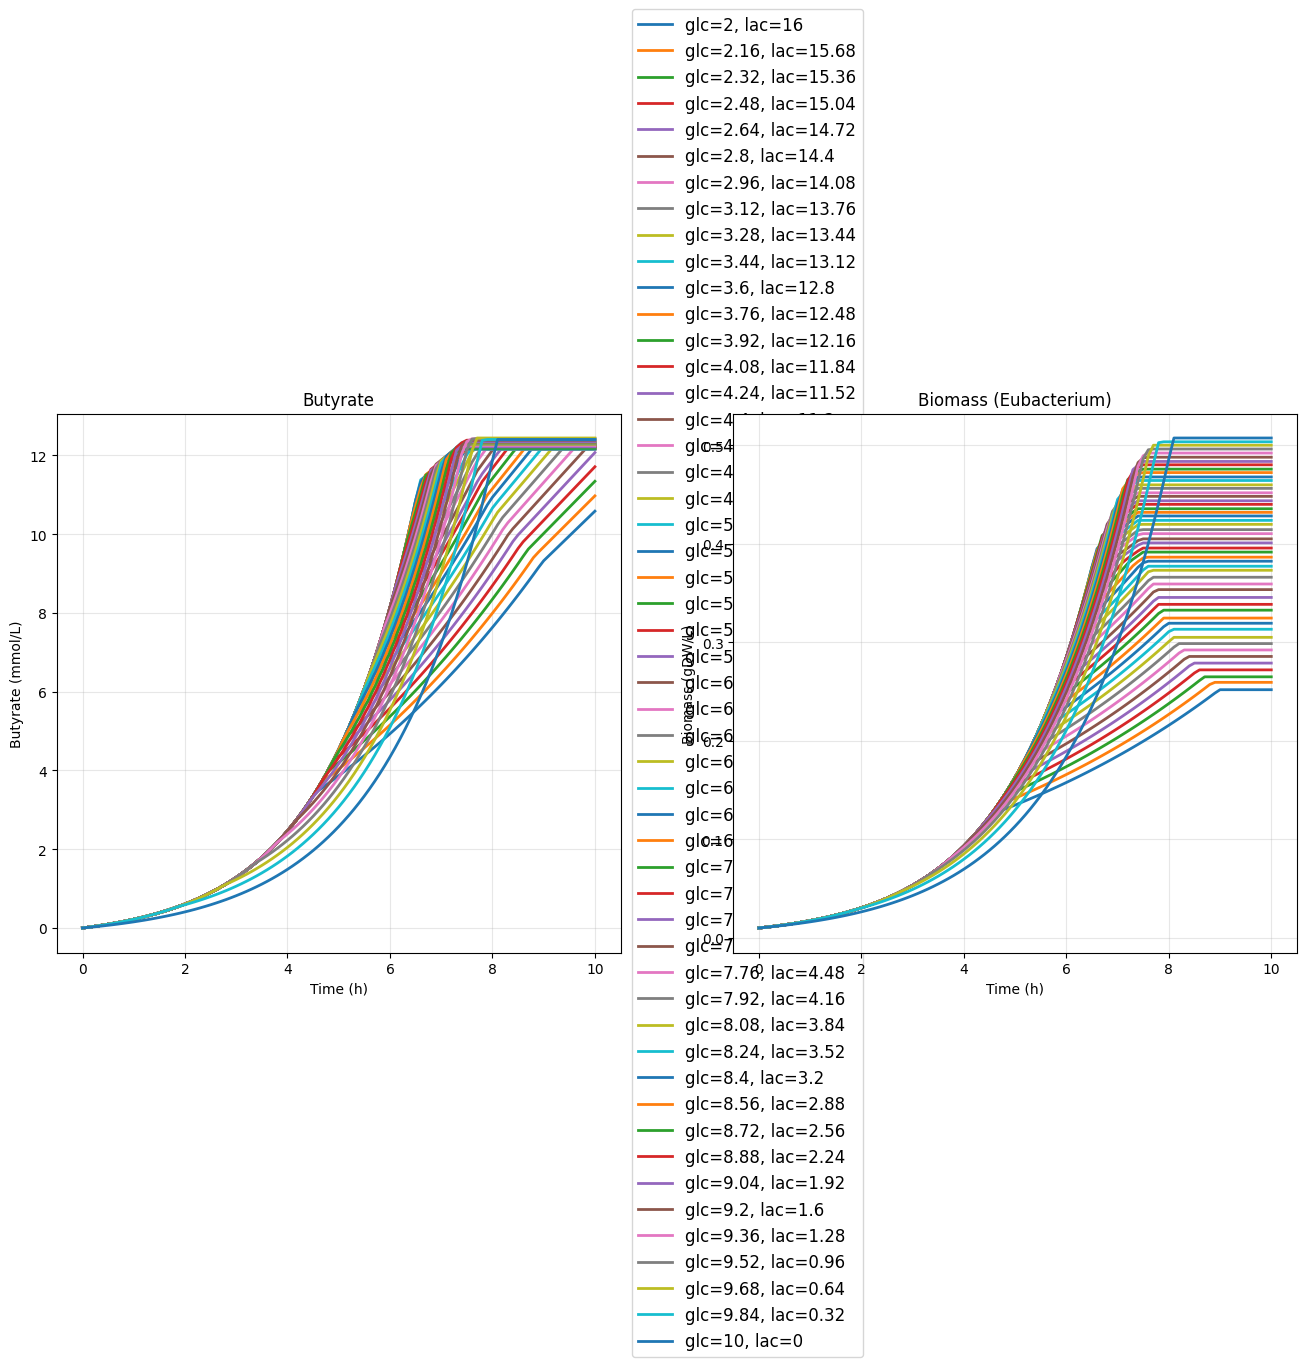

In [6]:
t_step = 0.1

keys = sorted(simulations.keys())
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(keys)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharex=True)

for (glc, lac), col in zip(keys, colors):
    sim = simulations[(glc, lac)]

    # butyrate
    media = sim.get_metabolite_time_series()
    if "but[e]" in media.columns:
        time = np.arange(len(media)) * t_step

        ax1.plot(time, media["but[e]"].values, linewidth=2, label=f"glc={glc:g}, lac={lac:g}")

    # biomass
    biomass = sim.total_biomass["Eubacterium"].values
    time_b = np.arange(len(biomass)) * t_step

    ax2.plot(time_b, biomass, linewidth=2)

ax1.set_title("Butyrate")
ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Butyrate (mmol/L)")
ax1.grid(alpha=0.3)
#ax1.legend(fontsize=12, ncol=2)
# just change the legend call (bigger text + bigger handles)
# ax1.legend(fontsize=12, ncol=2, loc="best", handlelength=3, frameon=True)
# put legend to the right of ax1 (outside the plot)
ax1.legend(
    fontsize=12,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.0,
    frameon=True
)

# make room on the right so it doesn't get cut off
plt.tight_layout(rect=[0, 0, 0.80, 1])

ax2.set_title("Biomass (Eubacterium)")
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Biomass (gDW/L)")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

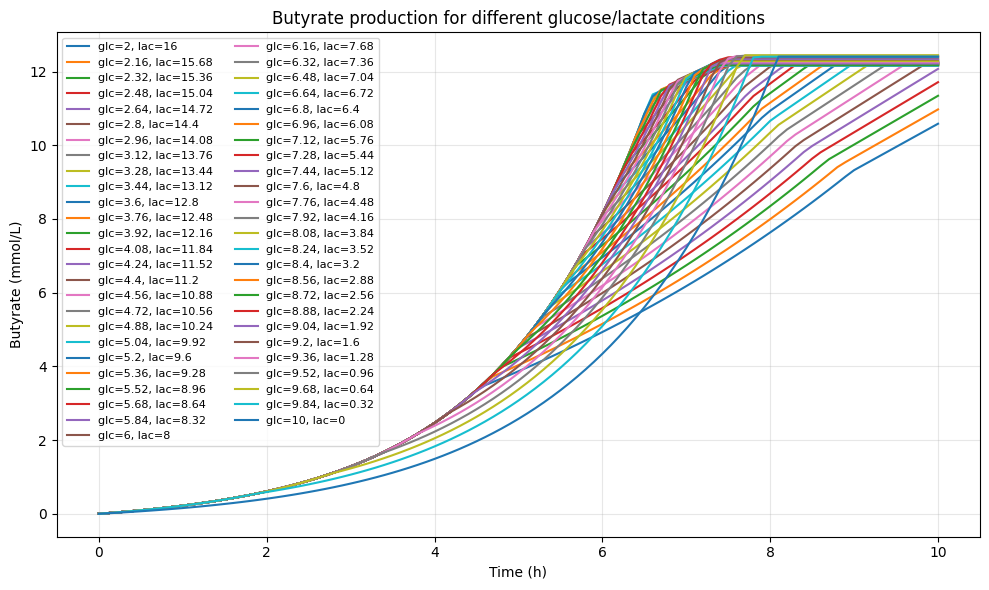

In [7]:
t_step = 0.1 

plt.figure(figsize=(10, 6))

for (glc, lac) in sorted(simulations.keys()):

    sim = simulations[(glc, lac)]
    media = sim.get_metabolite_time_series()

    time = np.arange(len(media)) * t_step
    but = media["but[e]"].values

    plt.plot(time, but, label=f"glc={glc:g}, lac={lac:g}")

plt.xlabel("Time (h)")
plt.ylabel("Butyrate (mmol/L)")
plt.title("Butyrate production for different glucose/lactate conditions")
plt.legend(fontsize=8, ncol=2)  # adjust ncol if many lines
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# cmap = plt.cm.viridis
# colors = cmap(np.linspace(0, 1, len(keys)))
#color=col,

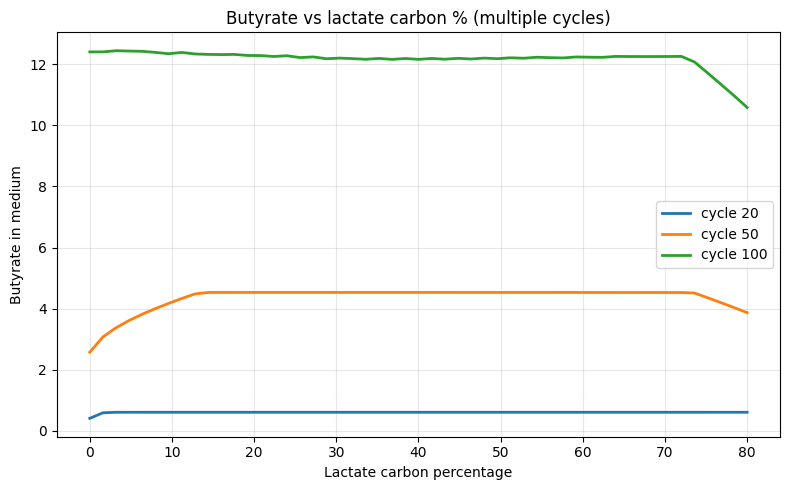

In [ ]:
cycles = [20, 50, 100]  

lacC_pct_list = []
but_at_cycle = {c: [] for c in cycles}

for (glc, lac), sim in sorted(simulations.items()):
    media = sim.get_metabolite_time_series()

    # x-axis: lactate carbon %
    denomC = 6*glc + 3*lac
    lacC_pct = 100.0 * (3*lac / denomC) if denomC > 0 else np.nan
    lacC_pct_list.append(lacC_pct)

    # y-axis: butyrate at selected cycles
    but_series = media["but[e]"].values if "but[e]" in media.columns else None
    for c in cycles:
        if but_series is None or c >= len(but_series):
            but_at_cycle[c].append(np.nan)
        else:
            but_at_cycle[c].append(but_series[c])

plt.figure(figsize=(8, 5))
for c in cycles:
    plt.plot(lacC_pct_list, but_at_cycle[c], linewidth=2, label=f"cycle {c}")

plt.xlabel("Lactate carbon percentage")
plt.ylabel("Butyrate in medium")
plt.title("Butyrate vs lactate carbon % (multiple cycles)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# lacC_pct_list = []
# buf_pct_list = []
# labels = []

# for (glc, lac), sim in sorted(simulations.items()):
#     media = sim.get_metabolite_time_series()

#     # final concentrations
#     but0 = media["but[e]"].values[0] if "but[e]" in media.columns else np.nan
#     #butf = media["but[e]"].values[-1] if "but[e]" in media.columns else np.nan
#     butf = media["but[e]"].values[100] if "but[e]" in media.columns else np.nan

#     #lacf = media["lac_L[e]"].values[-1] if "lac_L[e]" in media.columns else 0.0  # if not tracked, assume 0

#     # lactate percent in feed (carbon-based)
#     denomC = 6*glc + 3*lac
#     lacC_pct = 100.0 * (3*lac / denomC) if denomC > 0 else np.nan

#     lacC_pct_list.append(lacC_pct)
#     buf_pct_list.append(butf)
#     labels.append(f"glc={glc:g}, lac={lac:g}")

# # scatter plot: yield (%) vs lactate carbon %
# plt.figure(figsize=(8, 5))
# #plt.scatter(lacC_pct_list, buf_pct_list)
# plt.plot(lacC_pct_list, buf_pct_list, 'r-', linewidth=2)

# plt.xlabel("Lactate carbon percentage")
# plt.ylabel("Butyrate produced @ 10hrs (mmol)")
# plt.title("Butyrate vs lactate (percent)")
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

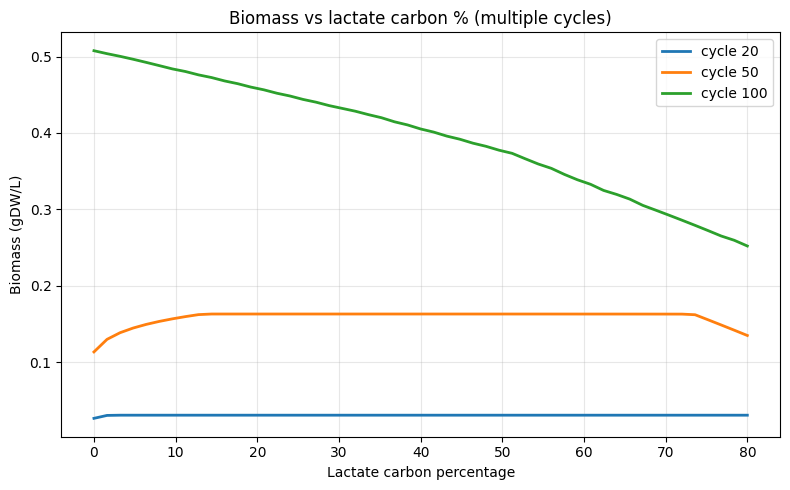

In [ ]:
cycles = [20, 50, 100]  

lacC_pct_list = []
biomass_at_cycle = {c: [] for c in cycles}
labels = []

for (glc, lac), sim in sorted(simulations.items()):
    # x-axis: lactate carbon %
    denomC = 6*glc + 3*lac
    lacC_pct = 100.0 * (3*lac / denomC) if denomC > 0 else np.nan
    lacC_pct_list.append(lacC_pct)
    labels.append(f"glc={glc:g}, lac={lac:g}")

    # y-axis: biomass at selected cycles
    b = sim.total_biomass["Eubacterium"].values
    for c in cycles:
        biomass_at_cycle[c].append(b[c] if c < len(b) else np.nan)

plt.figure(figsize=(8, 5))
for c in cycles:
    plt.plot(lacC_pct_list, biomass_at_cycle[c], linewidth=2, label=f"cycle {c}")

plt.xlabel("Lactate carbon percentage")
plt.ylabel("Biomass (gDW/L)")
plt.title("Biomass vs lactate carbon % (multiple cycles)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

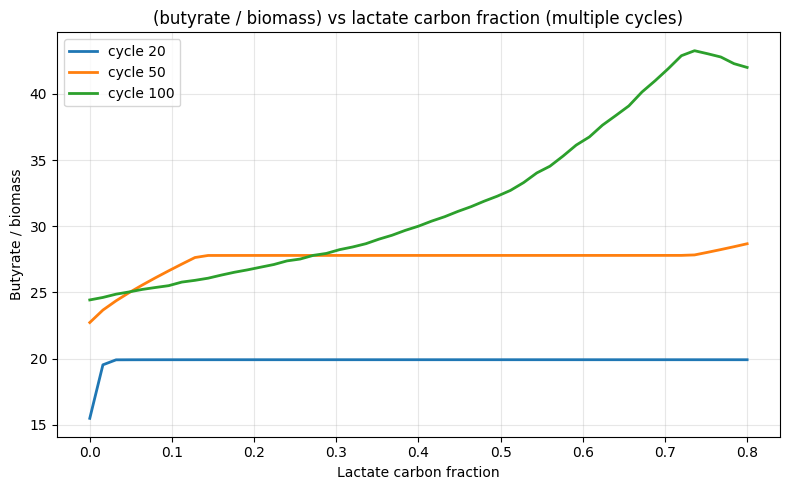

In [ ]:
cycles = [20, 50, 100]  

lacC_frac_list = []  # x-axis (0 to 1)
ratio_at_cycle = {c: [] for c in cycles}
labels = []

for (glc, lac), sim in sorted(simulations.items()):
    media = sim.get_metabolite_time_series()

    # x-axis: lactate carbon fraction
    denomC = 6*glc + 3*lac
    lacC_frac = (3*lac / denomC) if denomC > 0 else np.nan
    lacC_frac_list.append(lacC_frac)
    labels.append(f"glc={glc:g}, lac={lac:g}")

    # time series
    but_series = media["but[e]"].values if "but[e]" in media.columns else None
    b_series = sim.total_biomass["Eubacterium"].values

    # y-axis: ratio at selected cycles
    for c in cycles:
        if but_series is None or c >= len(but_series) or c >= len(b_series) or b_series[c] == 0:
            ratio_at_cycle[c].append(np.nan)
        else:
            ratio_at_cycle[c].append(but_series[c] / b_series[c])

plt.figure(figsize=(8, 5))
for c in cycles:
    plt.plot(lacC_frac_list, ratio_at_cycle[c], linewidth=2, label=f"cycle {c}")

plt.xlabel("Lactate carbon fraction")
plt.ylabel("Butyrate / biomass")
plt.title("(butyrate / biomass) vs lactate carbon fraction (multiple cycles)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# lacC_pct_list = []
# ratio_pct_list = []
# labels = []

# for (glc, lac), sim in sorted(simulations.items()):
#     media = sim.get_metabolite_time_series()

#     # final concentrations
#     but0 = media["but[e]"].values[0] if "but[e]" in media.columns else np.nan
#     #butf = media["but[e]"].values[-1] if "but[e]" in media.columns else np.nan
#     butf = media["but[e]"].values[100] if "but[e]" in media.columns else np.nan
#     b = sim.total_biomass["Eubacterium"].values
#     b_final = b[100]

#     ratio = butf / b_final 

#     #lacf = media["lac_L[e]"].values[-1] if "lac_L[e]" in media.columns else 0.0  # if not tracked, assume 0

#     # lactate percent in feed (carbon-based)
#     denomC = 6*glc + 3*lac
#     #denomC = 6*glc 
#     lacC_pct = (3*lac / denomC) if denomC > 0 else np.nan

#     lacC_pct_list.append(lacC_pct)
#     ratio_pct_list.append(ratio)
#     labels.append(f"glc={glc:g}, lac={lac:g}")

# # scatter plot: yield (%) vs lactate carbon %
# plt.figure(figsize=(8, 5))
# #plt.scatter(lacC_pct_list, buf_pct_list)
# plt.plot(lacC_pct_list, ratio_pct_list, 'r-', linewidth=2)

# plt.xlabel("lactate carbon fraction")
# plt.ylabel("ratio @ 10hrs (mmol butyrate per gDW )")
# plt.title("(butyrate / biomass) vs lactate carbon fraction")
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

In [11]:
# lacC_pct_list = []
# yield_pct_list = []
# labels = []

# for (glc, lac), sim in sorted(simulations.items()):
#     media = sim.get_metabolite_time_series()

#     # final concentrations
#     but0 = media["but[e]"].values[0] if "but[e]" in media.columns else np.nan
#     #butf = media["but[e]"].values[-1] if "but[e]" in media.columns else np.nan
#     butf = media["but[e]"].values[100] if "but[e]" in media.columns else np.nan

#     lacf = media["lac_L[e]"].values[-1] if "lac_L[e]" in media.columns else 0.0  # if not tracked, assume 0

#     # amounts (simple)
#     but_made = butf - but0
#     lac_consumed = float(lac) - float(lacf)

#     # lactate percent in feed (carbon-based)
#     denomC = 6*glc + 3*lac
#     lacC_pct = 100.0 * (3*lac / denomC) if denomC > 0 else np.nan

#     # butyrate vs lactate "percentage" = yield on consumed lactate
#     yld_pct = 100.0 * (but_made / lac_consumed) if lac_consumed > 0 else np.nan

#     lacC_pct_list.append(lacC_pct)
#     yield_pct_list.append(yld_pct)
#     labels.append(f"glc={glc:g}, lac={lac:g}")

# # scatter plot: yield (%) vs lactate carbon %
# plt.figure(figsize=(8, 5))
# plt.scatter(lacC_pct_list, yield_pct_list)
# #plt.plot(lacC_pct_list, yield_pct_list, 'r-', linewidth=2)

# plt.xlabel("Lactate in feed (carbon %, 3C vs 6C)")
# plt.ylabel("100 * (butyrate made / lactate consumed)")
# plt.title("Butyrate vs lactate (percent)")
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

In [12]:
# lacC_pct = []
# final_biomass = []

# for (glc, lac), sim in sorted(simulations.items()):
#     # lactate carbon % in starting feed
#     denomC = 6*glc + 3*lac
#     pct = 100.0 * (3*lac / denomC) if denomC > 0 else np.nan

#     # final biomass
#     b = sim.total_biomass["Eubacterium"].values
#     b_final = b[-1]
#     #biomass_increase.append(b[-1] - b[0]) 
#     #max_biomass.append(np.max(b))

#     lacC_pct.append(pct)
#     final_biomass.append(b_final)

# plt.figure(figsize=(7, 5))
# plt.scatter(lacC_pct, final_biomass)
# plt.xlabel("Lactate in feed (carbon %)")
# plt.ylabel("Final biomass (gDW/L)")
# plt.title("Final biomass vs lactate carbon %")
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

In [13]:
# lacC_pct = []
# final_biomass = []

# for (glc, lac), sim in sorted(simulations.items()):
#     # lactate carbon % in starting feed
#     # denomC = 6*glc + 3*lac
#     # pct = 100.0 * (3*lac / denomC) if denomC > 0 else np.nan

#     # final biomass
#     b = sim.total_biomass["Eubacterium"].values
#     b_final = b[-1]
#     #biomass_increase.append(b[-1] - b[0]) 
#     #max_biomass.append(np.max(b))

#     lacC_pct.append(pct)

In [ ]:
# import cobra as cb
# import cometspy as c
# import numpy as np 
# import matplotlib.pyplot as plt  
# import warnings
# import math
# warnings.filterwarnings('ignore', category=FutureWarning)

# # Load model
# model_1 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')

# # # Relax ATP maintenance reactions
# # for rxn in model_1.reactions:
# #     if rxn.id.upper().startswith("ATPM"):
# #         rxn.lower_bound = 0.0

# # Set default bounds for all exchanges: 
# for rxn in model_1.exchanges:
#     rxn.lower_bound = 0.0
#     rxn.upper_bound = 1000.0

# # Exchange list
# all_exchanges_cobra = [rxn.id for rxn in model_1.exchanges]
# print("Exchange reactions in model:", len(all_exchanges_cobra))

# # External metabolite -> exchange reaction 
# met_to_ex = {met.id: rxn.id for rxn in model_1.exchanges for met in rxn.metabolites if met.compartment == 'e'}
# print("External metabolites with mapped exchanges:", len(met_to_ex))

# # Medium
# trace_metabolites = set([      
#     'h2o[e]', 'pi[e]', 'fe2[e]', 'fe3[e]', 'zn2[e]', 'so4[e]', 'cu2[e]', 'k[e]', 'mg2[e]',
#     'mn2[e]', 'cd2[e]', 'cl[e]', 'ca2[e]', 'cobalt2[e]', 'ribflv[e]',
#     'pnto_R[e]', 'nac[e]', 'his_L[e]', 'asn_L[e]', 'glycys[e]', 'lys_L[e]', 'ala_L[e]',
#     'met_L[e]',  'leu_L[e]', 'hxan[e]',
# ])

# # Limited medium 
# base_media = {
#     "nh4[e]": 20.0,
#     "ser_L[e]": 10.0,   
# }

# # conditions 
# conditions = {
#     "Glucose 10": {
#         "glc_D[e]": 10.0,
#     },

#     "Glucose 9 (total carbon fixed)": {
#         "glc_D[e]": 9.0,
#         "lac_L[e]": 2.0,
#     },
#     "Glucose8 (total carbon fixed)": {
#         "glc_D[e]": 8.0,
#         "lac_L[e]": 4.0,
# },
#     "Glucose7 (individual substrates fixed)": {
#         "glc_D[e]": 7.0,
#         "lac_L[e]": 6.0,
#     },

#     "Glucose6 (individual substrates fixed)": {
#         "glc_D[e]": 6.0,
#         "lac_L[e]": 8.0,
#     },

#     "Glucose5 (individual substrates fixed)": {
#         "glc_D[e]": 5.0,
#         "lac_L[e]": 10.0,
#     },

#     "Glucose 4(individual substrates fixed)": {
#         "glc_D[e]": 4.0,
#         "lac_L[e]": 12.0,
#     },

#     "Glucose3 (individual substrates fixed)": {
#         "glc_D[e]": 3.0,
#         "lac_L[e]": 14.0,
#     },

#     "Glucose2 (individual substrates fixed)": {
#         "glc_D[e]": 2.0,
#         "lac_L[e]": 16.0,
#     },

#     "Glucose 1 (individual substrates fixed)": {
#         "glc_D[e]": 1.0,
#         "lac_L[e]": 18.0,
#     },

#     "Glucose0 (individual substrates fixed)": {
#         "glc_D[e]": 0.0,
#         "lac_L[e]": 20.0,
#     },
# }

# # Function to run simulation
# def run_simulation(carbon_sources, condition_name):
    
#     # Combine medium
#     lb_media = {**base_media, **carbon_sources}
#     medium = list(trace_metabolites | set(lb_media.keys()))
#     print(f"Condition: {condition_name}")
#     print(f"Carbon sources: {list(carbon_sources.keys())}")
   
#     model_copy = model_1.copy()
#     model_copy.id = "Eubacterium"
#     comets_model = c.model(model_copy)
    
#     # Set objective 
#     comets_model.obj_style = "MAXIMIZE_OBJECTIVE_FLUX" #"MAX_OBJECTIVE_MIN_TOTAL"

#     comets_model.open_exchanges()
    
#     # Initial population
#     comets_model.initial_pop = [0, 0, 0.01]
    
#     # Clean non-EX reactions from EXCH column
#     ex_mask = comets_model.reactions["EXCH"].isin([True, "True"])
#     exchanges_df = comets_model.reactions[ex_mask]
#     for name in exchanges_df["REACTION_NAMES"]:
#         name = str(name)
#         if not name.startswith("EX_"):
#             comets_model.reactions.loc[comets_model.reactions["REACTION_NAMES"] == name, "EXCH"] = False
#             comets_model.reactions.loc[comets_model.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0


#     # mask = comets_model.reactions["REACTION_NAMES"] == "EX_lac_L(e)"
#     # if mask.any():
#     #     comets_model.reactions.loc[mask, "LB"] = 0.0
    
#     # Layout
#     layout = c.layout([comets_model])
#     layout.grid = [1, 1]
    
#     # Track all external metabolites
#     all_ex_mets = set(met_to_ex.keys())
#     for met in all_ex_mets:
#         layout.set_specific_metabolite(met, 0.0)
#         layout.set_specific_refresh(met, 0.0)
    
#     # Unlimited trace elements
#     for met in trace_metabolites & all_ex_mets:
#         layout.set_specific_metabolite(met, 1000.0)
#         layout.set_specific_static(met, 1000)
    
#     # Limited nutrients 
#     for met in lb_media:
#         if met in all_ex_mets:
#             layout.set_specific_metabolite(met, lb_media[met])
#             layout.set_specific_refresh(met, 0.0)
    
#     # Parameters
#     vol = 0.1
#     params = c.params()
#     params.set_param("spaceWidth", vol**(1/3))
#     params.set_param("defaultVmax", 10.)
#     params.set_param("defaultKm", 0.01)
    
#     t_step = 0.1
#     t_total = 200
#     params.set_param("timeStep", t_step)
#     params.set_param("maxSpaceBiomass", 10.)
#     params.set_param("minSpaceBiomass", 1e-11)
#     params.set_param("maxCycles", t_total)
#     params.set_param("writeMediaLog", True)
#     params.set_param("MediaLogRate", 1)
#     params.set_param("writeFluxLog", True)
#     params.set_param("FluxLogRate", 1)
#     params.set_param("writeBiomassLog", True)
#     params.set_param("BiomassLogRate", 1)
#     params.set_param("exchangestyle", "Monod Style")
    
#     sim = c.comets(layout, params)
#     sim.run()
    
#     return sim, condition_name


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Exchange reactions in model: 120
External metabolites with mapped exchanges: 119
Condition: Glucose 10
Carbon sources: ['glc_D[e]']

Running COMETS simulation ...

Debug Here ...
Done!
Condition: Glucose 9 (total carbon fixed)
Carbon sources: ['glc_D[e]', 'lac_L[e]']

Running COMETS simulation ...

Debug Here ...
Done!
Condition: Glucose8 (total carbon fixed)
Carbon sources: ['glc_D[e]', 'lac_L[e]']

Running COMETS simulation ...

Debug Here ...
Done!
Condition: Glucose7 (individual substrates fixed)
Carbon sources: ['glc_D[e]', 'lac_L[e]']

Running COMETS simulation ...

Debug Here ...
Done!
Condition: Glucose6 (individual substrates fixed)
Carbon sources: ['glc_D[e]', 'lac_L[e]']

Running COMETS simulation ...

Debug Here ...
Done!
Condition: Glucose5 (individual substrates fixed)
Carbon sources: ['glc_D[e]', 'lac_L[e]']

Running COMETS simulation ...

Debug Here ...
Done!
Condition: Glucose 4(individual substrates fixed)
Carbon sources: ['glc_D[e]', 'lac_L[e]']

Running COMETS simul

IndexError: list index out of range

In [ ]:



# # Run simulations
# simulations = {}
# for condition_name, carbon_sources in conditions.items():
#     sim, name = run_simulation(carbon_sources, condition_name)
#     simulations[condition_name] = sim

# # Extract data 
# def get_met_data(sim, metabolite):
#     media = sim.get_metabolite_time_series()
#     if metabolite in media.columns:
#         return media[metabolite].values


# def get_flux_data(sim, metabolite, model_name="Eubacterium"):

#     flux_df = sim.get_species_exchange_fluxes(model_name, threshold=1e-8)
#     met_reaction = metabolite.replace('[e]', '(e)')
#     flux_col = 'EX_' + met_reaction
    
#     if flux_col in flux_df.columns:
#         return flux_df[flux_col].values
#     else:
#         return np.array([])


# # Extract data for all conditions
# t_step = 0.1
# data = {}
# colors = ['blue', 'red', 'orange']  
# linestyles = ['-', '-', '--']  

# for i, (condition_name, sim) in enumerate(simulations.items()):
#     time = np.arange(len(sim.total_biomass)) * t_step
#     data[condition_name] = {
#         'time': time,
#         'butyrate': get_met_data(sim, 'but[e]'),
#         'biomass': sim.total_biomass['Eubacterium'].values,
#         'glucose': get_met_data(sim, 'glc_D[e]'),
#         'lactate': get_met_data(sim, 'lac_L[e]'),
#         'but_flux': get_flux_data(sim, 'but[e]'),
#         'glc_flux': get_flux_data(sim, 'glc_D[e]'),
#         'lac_flux': get_flux_data(sim, 'lac_L[e]'),
#         'color': colors[i],
#         'linestyle': linestyles[i]
#     }

# # comparison plots
# fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# fig.suptitle('Effect of Lactate on Eubacterium: Controlled Comparisons', 
#              fontsize=16, fontweight='bold', y=0.98)

# # Row 1: Concentrations
# # Plot 1: Butyrate production
# ax = axes[0, 0]
# for condition_name, d in data.items():
#     ax.plot(d['time'], d['butyrate'], color=d['color'], linestyle=d['linestyle'], 
#             linewidth=2, label=condition_name)
# ax.set_xlabel('Time (h)', fontsize=12)
# ax.set_ylabel('Butyrate Concentration (mmol/L)', fontsize=12)
# ax.set_title('Butyrate Production', fontsize=14, fontweight='bold')
# ax.legend(fontsize=9)
# ax.grid(alpha=0.3)

# # Plot 2: Biomass growth
# ax = axes[0, 1]
# for condition_name, d in data.items():
#     ax.plot(d['time'], d['biomass'], color=d['color'], linestyle=d['linestyle'], 
#             linewidth=2, label=condition_name)
# ax.set_xlabel('Time (h)', fontsize=12)
# ax.set_ylabel('Biomass (gDW/L)', fontsize=12)
# ax.set_title('Biomass Growth', fontsize=14, fontweight='bold')
# ax.legend(fontsize=9)
# ax.grid(alpha=0.3)

# # Plot 3: Carbon source consumption
# ax = axes[0, 2]
# for condition_name, d in data.items():
#     ax.plot(d['time'], d['glucose'], color=d['color'], linestyle=d['linestyle'], 
#             linewidth=2, label=f'Glucose ({condition_name})', alpha=0.7)
#     if 'Lactate' in condition_name:
#         ax.plot(d['time'], d['lactate'], color=d['color'], linestyle=':', 
#                 linewidth=2, label=f'Lactate ({condition_name})', alpha=0.7)
# ax.set_xlabel('Time (h)', fontsize=12)
# ax.set_ylabel('Concentration (mmol/L)', fontsize=12)
# ax.set_title('Carbon Source Consumption', fontsize=14, fontweight='bold')
# ax.legend(fontsize=8, ncol=1)
# ax.grid(alpha=0.3)

# # Row 2: Fluxes
# # Plot 4: Butyrate flux
# ax = axes[1, 0]
# for condition_name, d in data.items():
#     if len(d['but_flux']) > 0:
#         time_flux = d['time'][:len(d['but_flux'])]
#         ax.plot(time_flux, d['but_flux'], color=d['color'], linestyle=d['linestyle'], 
#                 linewidth=2, label=condition_name)
# ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
# ax.set_xlabel('Time (h)', fontsize=12)
# ax.set_ylabel('Butyrate Flux (mmol/gDW/h)', fontsize=12)
# ax.set_title('Butyrate Production Flux', fontsize=14, fontweight='bold')
# ax.legend(fontsize=9)
# ax.grid(alpha=0.3)

# # Plot 5: Glucose flux
# ax = axes[1, 1]
# for condition_name, d in data.items():
#     if len(d['glc_flux']) > 0:
#         time_flux = d['time'][:len(d['glc_flux'])]
#         ax.plot(time_flux, d['glc_flux'], color=d['color'], linestyle=d['linestyle'], 
#                 linewidth=2, label=condition_name)
# ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
# ax.set_xlabel('Time (h)', fontsize=12)
# ax.set_ylabel('Glucose Flux (mmol/gDW/h)', fontsize=12)
# ax.set_title('Glucose Consumption Flux', fontsize=14, fontweight='bold')
# ax.legend(fontsize=9)
# ax.grid(alpha=0.3)

# # Plot 6: Lactate flux 
# ax = axes[1, 2]
# for condition_name, d in data.items():
#     if 'Lactate' in condition_name and len(d['lac_flux']) > 0:
#         time_flux = d['time'][:len(d['lac_flux'])]
#         ax.plot(time_flux, d['lac_flux'], color=d['color'], linestyle=d['linestyle'], 
#                 linewidth=2, label=condition_name)
# ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
# ax.set_xlabel('Time (h)', fontsize=12)
# ax.set_ylabel('Lactate Flux (mmol/gDW/h)', fontsize=12)
# ax.set_title('Lactate Consumption Flux', fontsize=14, fontweight='bold')
# ax.legend(fontsize=9)
# ax.grid(alpha=0.3)

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()